In [59]:
# import h5py
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# train_file = "../data/old/MJD_Train_0.hdf5"


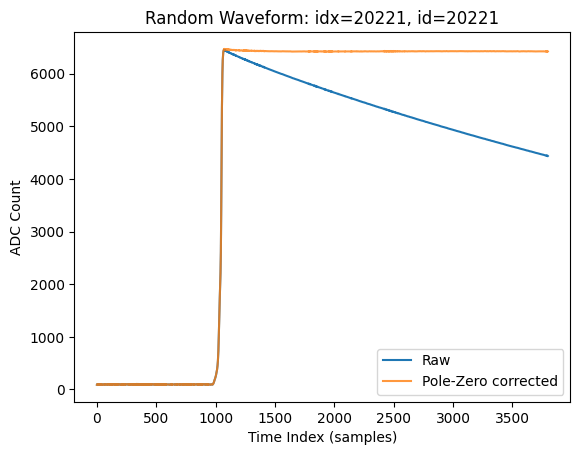

PZ used: True reason: 
ID: 20221
Computed LQ80: -2920678.653496962


In [60]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

train_file = "../data/old/MJD_Train_0.hdf5"

def estimate_baseline(y, n_samples=200):
    y0 = np.asarray(y, dtype=float)[:n_samples]
    return float(np.mean(y0)), float(np.std(y0))

def double_exp(t, a, tau1, b, tau2):
    return a * np.exp(-t / tau1) + b * np.exp(-t / tau2)

def pole_zero_correction(waveform, use_pz=True, n_baseline=200, start_frac=0.80):
    y = np.asarray(waveform, dtype=float)

    if not use_pz:
        return y.copy(), y.copy(), {"used": False}

    baseline = float(np.mean(y[:n_baseline]))
    y_sub = y - baseline

    peak = float(np.max(y_sub))
    if not np.isfinite(peak) or peak <= 0:
        return y.copy(), y.copy(), {"used": False, "reason": "bad peak"}

    target = start_frac * peak
    idx = np.where(y_sub >= target)[0]
    if len(idx) == 0:
        return y.copy(), y.copy(), {"used": False, "reason": "no crossing"}
    i_start = int(idx[0])

    tail = y_sub[i_start:]
    t = np.arange(tail.size, dtype=float)

    p0 = [0.9 * peak, 400.0, 0.1 * peak, 2000.0]
    bounds = ([0.0, 20.0, 0.0, 20.0], [5.0 * peak, 20000.0, 5.0 * peak, 20000.0])

    try:
        params, _ = curve_fit(double_exp, t, tail, p0=p0, bounds=bounds, maxfev=20000)
        model = double_exp(t, *params)

        m0 = float(model[0])
        if (not np.isfinite(m0)) or (m0 <= 0):
            return y.copy(), y.copy(), {"used": False, "reason": "bad model[0]"}

        model_norm = model / m0
        model_norm = np.clip(model_norm, 1e-6, None)

        corrected_tail_sub = tail / model_norm

        y_corr = y.copy()
        y_corr[i_start:] = corrected_tail_sub + baseline

        return y_corr, y_corr[i_start:], {"used": True, "baseline": baseline, "i_start": i_start, "params": params}

    except Exception as e:
        return y.copy(), y.copy(), {"used": False, "reason": str(e)}

def compute_LQ80(waveform):
    y = np.asarray(waveform, dtype=float)
    y_pz, _, _ = pole_zero_correction(y, use_pz=True, start_frac=0.80)

    baseline, _ = estimate_baseline(y)
    peak_val = float(np.max(y))
    target = baseline + 0.80 * (peak_val - baseline)

    idx = np.where(y >= target)[0]
    if len(idx) == 0:
        return np.nan
    i80 = int(idx[0])

    t = np.arange(len(y), dtype=float)
    area_raw = float(np.trapezoid(y[i80:], t[i80:]))
    area_corr = float(np.trapezoid(y_pz[i80:], t[i80:]))

    return area_raw - area_corr

with h5py.File(train_file, "r") as f:
    raw_waveform = np.array(f["raw_waveform"])
    ids = np.array(f["id"])

n_events, n_samples = raw_waveform.shape
time_index = np.arange(n_samples)

random_index = np.random.randint(0, n_events)
random_waveform = raw_waveform[random_index]

random_waveform_pz, _, info = pole_zero_correction(random_waveform, use_pz=True, start_frac=0.80)
lq80_value = compute_LQ80(random_waveform)

fig, ax = plt.subplots()
ax.plot(time_index, random_waveform, label="Raw")
ax.plot(time_index, random_waveform_pz, label="Pole-Zero corrected", alpha=0.8)
ax.set_title(f"Random Waveform: idx={random_index}, id={ids[random_index]}")
ax.set_xlabel("Time Index (samples)")
ax.set_ylabel("ADC Count")
ax.legend()
plt.show()

print("PZ used:", info.get("used"), "reason:", info.get("reason", ""))
print("ID:", ids[random_index])
print("Computed LQ80:", lq80_value)


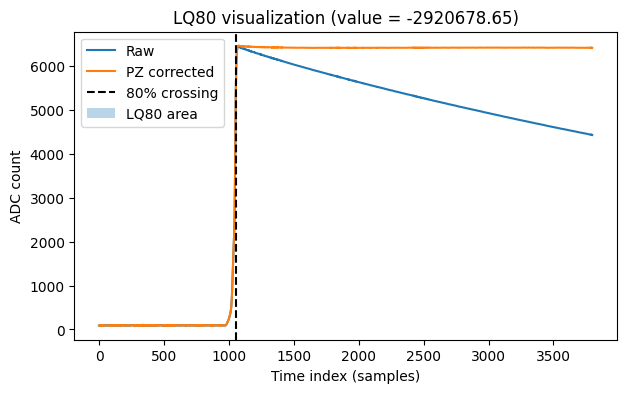

In [62]:
# ----- LQ80 visualization -----
y = random_waveform
y_pz = random_waveform_pz

baseline, _ = estimate_baseline(y)
peak = np.max(y)
target = baseline + 0.80 * (peak - baseline)

idx = np.where(y >= target)[0]
i80 = int(idx[0])

t = time_index

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(t, y, label="Raw", color="C0")
ax.plot(t, y_pz, label="PZ corrected", color="C1")

# 80% line
ax.axvline(i80, color="k", linestyle="--", label="80% crossing")

# shaded LQ80 region
ax.fill_between(
    t[i80:],
    y[i80:],
    y_pz[i80:],
    where=(y[i80:] >= y_pz[i80:]),
    alpha=0.3,
    label="LQ80 area"
)

ax.set_xlabel("Time index (samples)")
ax.set_ylabel("ADC count")
ax.set_title(f"LQ80 visualization (value = {lq80_value:.2f})")
ax.legend()
plt.show()
